In [1]:
import matplotlib.pyplot as plt
import os
from datetime import datetime

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image

import sklearn
from sklearn import metrics
import seaborn as sns

tf.__version__, sklearn.__version__

('2.14.0', '1.3.2')

In [2]:
SEED = 42
tf.random.set_seed(SEED)

# 1. Setup dataset

data_file= F:\GDrive\Programming\Python\MyProject\TekapawSoft\cuisineimageclassifier-folder\cuisineimageclassifier-jupyter\dataset\images.zip
OUTPUT_DIR= WindowsPath('F:/GDrive/Programming/Python/MyProject/TekapawSoft/cuisineimageclassifier-folder/cuisineimageclassifier-jupyter/output')
MODEL_DIR= WindowsPath('F:/GDrive/Programming/Python/MyProject/TekapawSoft/cuisineimageclassifier-folder/cuisineimageclassifier-jupyter/model')
confirm dataset size:
F:\GDrive\Programming\Python\MyProject\TekapawSoft\cuisineimageclassifier-folder\cuisineimageclassifier-jupyter\output\unzip_dir\images\train\salad 100
F:\GDrive\Programming\Python\MyProject\TekapawSoft\cuisineimageclassifier-folder\cuisineimageclassifier-jupyter\output\unzip_dir\images\train\sushi 100
F:\GDrive\Programming\Python\MyProject\TekapawSoft\cuisineimageclassifier-folder\cuisineimageclassifier-jupyter\output\unzip_dir\images\train\tofu 100
F:\GDrive\Programming\Python\MyProject\TekapawSoft\cuisineimageclassifier-folder\cuisineima

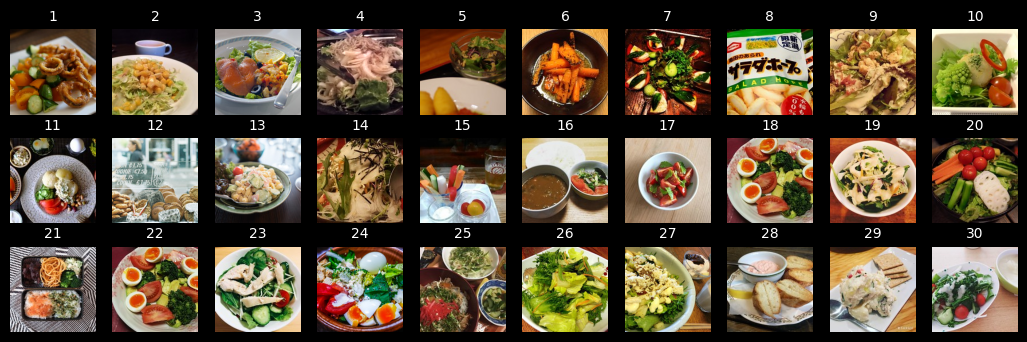

sample sushi images:


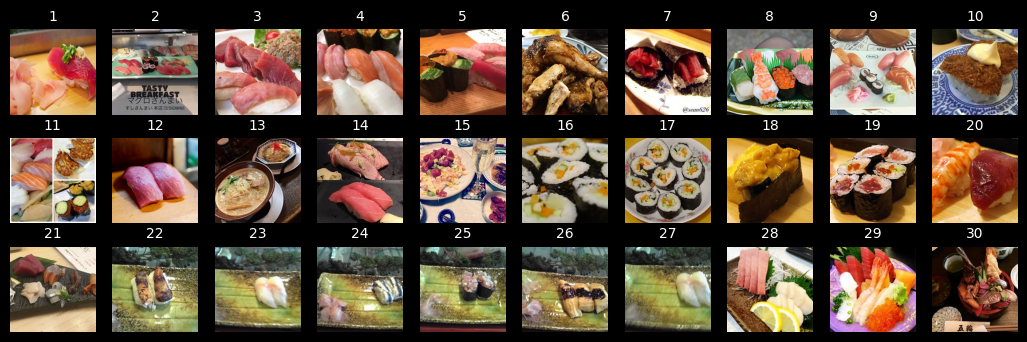

sample tofu images:


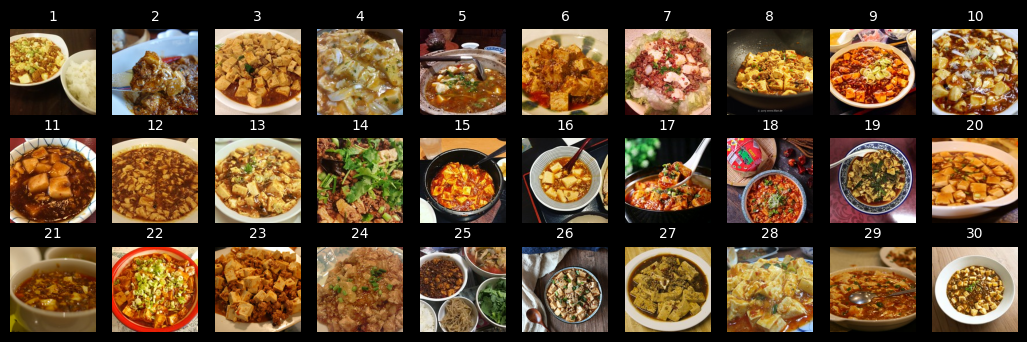

In [3]:
%run "./setup_dataset.ipynb"

# 2. Train

### 2.1 modeling

In [4]:
# define model

def create_model(activation="relu", dropout=0.1, input_shape=(150,150,3), nb_classes=3):
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3,3), input_shape=input_shape))
    model.add(layers.Activation(activation))
    model.add(layers.Dropout(dropout))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Conv2D(64, (3,3)))
    model.add(layers.Activation(activation))
    model.add(layers.Dropout(dropout))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Conv2D(128, (3,3)))
    model.add(layers.Activation(activation))
    model.add(layers.Dropout(dropout))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Conv2D(128, (3,3)))
    model.add(layers.Activation(activation))
    model.add(layers.Dropout(dropout))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(512, activation=activation))
    model.add(layers.Dense(nb_classes, activation='softmax'))

    return model

    
model = create_model(activation="relu", dropout=0.3, input_shape=(150,150,3), nb_classes=3)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 activation (Activation)     (None, 148, 148, 32)      0         
                                                                 
 dropout (Dropout)           (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 72, 72, 64)        0         
                                                        

In [5]:
# compile model

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False),
              metrics=['accuracy'])
model

In [6]:
# # define generator

# train_datagen = ImageDataGenerator(rescale=1./255)
# test_datagen = ImageDataGenerator(rescale=1./255)

# batch_size = 10

# train_generator = train_datagen.flow_from_directory(
#     train_dir,
#     target_size=(150, 150),  # Resize all images to 150x150.
#     batch_size=batch_size,
#     class_mode='categorical',
# )

# validation_generator = test_datagen.flow_from_directory(
#     validation_dir,
#     target_size=(150, 150),
#     batch_size=batch_size,
#     class_mode='categorical',
# )

In [7]:
# define generator with data augumentation

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 10

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),  # Resize all images to 150x150.
    batch_size=batch_size,
    class_mode='categorical',
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',
)

Found 300 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


In [8]:
# set early-stopping

best_model_h5 = "best_model_{}.h5".format(tf.__version__)

callbacks = [EarlyStopping(monitor="val_loss", min_delta=1e-5, patience=5, mode="auto", verbose=0),
             ModelCheckpoint(filepath=os.path.join(MODEL_DIR, best_model_h5), monitor="val_loss", save_best_only=True, save_weights_only=False),
             ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=10),  # divide learning_rate by 10 when the callback is invoked.
            ]

In [9]:
# train

epochs = 30
# epochs = 2

begin_time = datetime.now()

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1,
)

print("\nElapsed Time: {}\t{}".format(datetime.now() - begin_time, datetime.now()))

Epoch 1/30
30/30 [==============================] - 25s 750ms/step - loss: 1.3089 - accuracy: 0.3367 - val_loss: 1.0893 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/30


C:\Python\envcic\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


30/30 [==============================] - 21s 696ms/step - loss: 1.0756 - accuracy: 0.4233 - val_loss: 1.0690 - val_accuracy: 0.4267 - lr: 0.0010
Epoch 3/30
30/30 [==============================] - 21s 694ms/step - loss: 0.9804 - accuracy: 0.5000 - val_loss: 0.9792 - val_accuracy: 0.5467 - lr: 0.0010
Epoch 4/30
30/30 [==============================] - 21s 692ms/step - loss: 0.9868 - accuracy: 0.5267 - val_loss: 1.0651 - val_accuracy: 0.4433 - lr: 0.0010
Epoch 5/30
30/30 [==============================] - 21s 695ms/step - loss: 0.9948 - accuracy: 0.5200 - val_loss: 1.0289 - val_accuracy: 0.5600 - lr: 0.0010
Epoch 6/30
30/30 [==============================] - 21s 691ms/step - loss: 0.9518 - accuracy: 0.5667 - val_loss: 0.9914 - val_accuracy: 0.5467 - lr: 0.0010
Epoch 7/30
30/30 [==============================] - 21s 691ms/step - loss: 0.9320 - accuracy: 0.6200 - val_loss: 0.9337 - val_accuracy: 0.5700 - lr: 0.0010
Epoch 8/30
30/30 [==============================] - 21s 696ms/step - loss: 

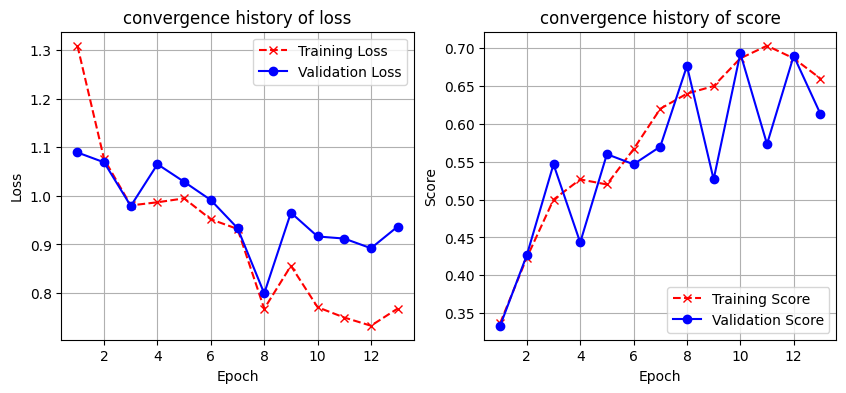

In [10]:
# draw convergence history

def draw_convergence_history(history, save_file=None):
    """draw convergence history"""
    
    score = list(history.keys())[1]
    val_score = list(history.keys())[3]

    fig, ax = plt.subplots(1,2, figsize=(10,4), facecolor="w")
    
    # obtain the history of training loss and validation loss
    training_loss = history["loss"]
    validation_loss = history["val_loss"]

    # prepare epoch list
    epoch_count = range(1, len(training_loss) + 1)
    
    # plot "loss convergence" for training data and validation data
    ax[0].plot(epoch_count, training_loss, "rx--")  # r-- ro ro- ro--
    ax[0].plot(epoch_count, validation_loss, "bo-")
    
    ax[0].set_title("convergence history of loss")
    ax[0].legend(["Training Loss", "Validation Loss"], loc="upper right")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")
    ax[0].grid()

    # plot "accuracy convergence" for training data and validation data
    training_accuracy = history[score]
    validation_accuracy = history[val_score]
    
    ax[1].plot(epoch_count, training_accuracy, "rx--")  # r-- ro ro- ro--
    ax[1].plot(epoch_count, validation_accuracy, "bo-")
    
    ax[1].set_title("convergence history of score")
    ax[1].legend(["Training Score", "Validation Score"], loc="lower right")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Score")
    ax[1].grid()

    if save_file:
        plt.savefig(save_file)

    plt.show()
    plt.close()

draw_convergence_history(history.history, save_file=Path(OUTPUT_DIR, "convergence_history.png"))

### 2.2 Evaluation

In [11]:
# define generator

batch_size = 10

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',
)

Found 210 images belonging to 3 classes.


In [12]:
# calculate loss and accuracy

loss, accuracy = model.evaluate(test_generator, verbose=1)
print(f"{loss= :.4f}\t{accuracy= :.4f}")

21/21 [==============================] - 2s 102ms/step - loss: 0.8758 - accuracy: 0.7095
loss= 0.8758	accuracy= 0.7095


In [13]:
# predict testset

test_pred_dict = {}

for test_dir in test_dirs:
    pred = []
        
    for path in test_dir.iterdir():
#         print(path)
        img = image.load_img(path, target_size=(150, 150))
        img_tensor = image.img_to_array(img)
        img_tensor = np.expand_dims(img_tensor, axis=0)
        img_tensor /= 255.

        p = model.predict(img_tensor)[0]
        pred.append(np.argmax(p))
    
    test_pred_dict[test_dir.name] = pred


test_pred = [*test_pred_dict["salad"], *test_pred_dict["sushi"], *test_pred_dict["tofu"]]
print(test_pred)

1/1 [==============================] - 0s 41ms/step
[2, 0, 1, 2, 0, 0, 0, 1, 0, 2, 1, 0, 1, 0, 2, 2, 0, 1, 2, 1, 1, 1, 0, 2, 1, 1, 1, 0, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 0, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 0, 2, 0, 0, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [14]:
# create ture class list 

num_of_salad = len(os.listdir(test_salad_dir))
num_of_sushi = len(os.listdir(test_sushi_dir))
num_of_tofu = len(os.listdir(test_tofu_dir))

test_true = [*[0]*num_of_salad, *[1]*num_of_sushi, *[2]*num_of_tofu]
print(test_true)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [15]:
# classification report

report = metrics.classification_report(test_true, test_pred)

print(f"classification report on test dataset\n{report}")

classification report on test dataset
              precision    recall  f1-score   support

           0       0.94      0.21      0.35        70
           1       0.64      0.97      0.77        70
           2       0.76      0.94      0.84        70

    accuracy                           0.71       210
   macro avg       0.78      0.71      0.65       210
weighted avg       0.78      0.71      0.65       210



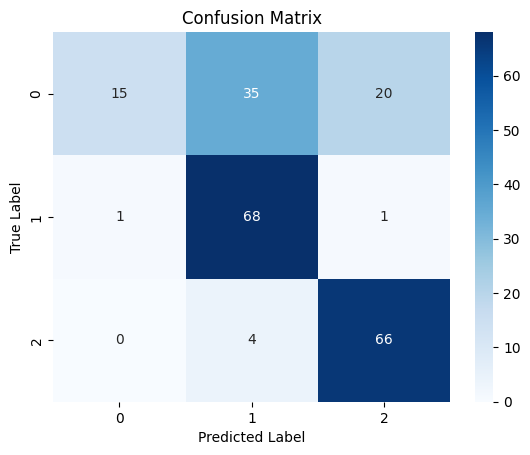

In [16]:
# confusion matrix

confusion_matrix = metrics.confusion_matrix(test_true, test_pred)

sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt="d")

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
    
plt.savefig(Path(OUTPUT_DIR, "confusionmatrix.png"))